In [1]:
!pip install nes-py
!pip install gym-super-mario-bros

In [2]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

In [4]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Creating Environment

In [6]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

In [7]:
ENV_NAME = 'SuperMarioBros-v3'
DISPLAY = True
NUM_OF_EPISODES = 50

In [8]:
env = gym_super_mario_bros.make(ENV_NAME)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
# env.render("rgb_array")

In [10]:
print(env.action_space)
env=JoypadSpace(env,COMPLEX_MOVEMENT)
print(env.action_space)
print(env.observation_space)
print(env.observation_space.shape)

Discrete(256)
Discrete(12)
Box(0, 255, (240, 256, 3), uint8)
(240, 256, 3)


In [11]:
obs = env.reset()
obs.shape

(240, 256, 3)

## Creating Model

array([[[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       ...,

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]],

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]],

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]]], dtype=uint8)
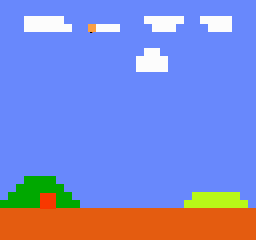

In [12]:
obs = env.reset()
obs

In [13]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = next_q_values_online.argmax(dim=1, keepdim=True)
                # Estimate the q-values for the selected actions using target q network
                next_q_values_target = th.gather(next_q_values, dim=1, index=next_actions_online).squeeze()
                # Compute target Q-value
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values_target

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)
            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long()).squeeze()

            # Compute loss (L2 or Huber loss)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))


In [14]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.
    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        self.n_samples = 512
        env = gym_super_mario_bros.make(ENV_NAME)
        # Sample initial states that will be used to monitor the estimated q-value
        self.start_obs = np.array([env.reset()[0] for _ in range(self.n_samples)], dtype=np.float32)

    def _on_training_start(self) -> None:
        # Create overestimation
        obs = th.tensor(self.start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.num_timesteps % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

monitor_dqn_value_cb = MonitorQValueCallback()

In [15]:
tensorboard_log = "data/tb/"

In [16]:
double_q = DoubleDQN(
            "MlpPolicy",
            env=env,
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102,
            )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [17]:
monitor_double_q_value_cb = MonitorQValueCallback()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [18]:
obs = env.reset()
obs.shape

(240, 256, 3)

In [19]:
from nes_py import NESEnv
_reset = NESEnv.reset

def reset(*args, **kwargs):
    obs_info = _reset(*args, **kwargs)
    obs, info = obs_info if type(obs_info) == tuple else (obs_info, {})
    return obs, info

NESEnv.reset = reset

"""
TypeError: JoypadSpace.reset() got an unexpected keyword argument 'seed'
was fixed using this code snippet only on windows
"""


"\nTypeError: JoypadSpace.reset() got an unexpected keyword argument 'seed'\nwas fixed using this code snippet only on windows\n"

In [20]:
# from nes_py import NESEnv
# _reset = NESEnv.reset

# def reset(*args, **kwargs):
#     obs_info = _reset(*args, **kwargs)
#     obs, info = obs_info if type(obs_info) == tuple else (obs_info, {})
#     return obs, info

# NESEnv.reset = reset

# JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

# above are the attempted workaround for "joypad reset error"

In [22]:
double_q.learn(int(1e4), log_interval=10, callback=monitor_double_q_value_cb)

RecursionError: maximum recursion depth exceeded